In [25]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import HuberRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

from MachineLearning import splitting_tr_te, unshuffled_CV, hyperparameter_tuning

import warnings
warnings.filterwarnings('ignore')

sns.set()

In [2]:
data = pd.read_csv("../data/portfolio65_6.0month_prediction.csv", index_col=0)

In [3]:
data = data.dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2370 entries, 146 to 2515
Data columns (total 30 columns):
 #   Column                                                             Non-Null Count  Dtype  
---  ------                                                             --------------  -----  
 0   65                                                                 2370 non-null   float64
 1   DAY(Date)                                                          2370 non-null   int64  
 2   MONTH(Date)                                                        2370 non-null   int64  
 3   NUMERIC_LAG(Date, 65, periods=126)                                 2370 non-null   float64
 4   NUMERIC_LAG(Date, 65, periods=127)                                 2370 non-null   float64
 5   NUMERIC_LAG(Date, 65, periods=128)                                 2370 non-null   float64
 6   NUMERIC_LAG(Date, 65, periods=129)                                 2370 non-null   float64
 7   NUMERIC_LAG(Date, 65, 

In [4]:
def splitting_tr_te(df, size=0.95):
    
    split_point = int(df.shape[0]*size)

    train = df.iloc[:split_point]
    test = df.iloc[split_point:]
    return train, test

df, df_test = splitting_tr_te(data)

In [5]:
# Models that I want to test out: Huber Regression, Random Forest, XGBoost, and LSTM
def unshuffled_CV(X, y, list_of_models, model_names, folds=5):
    results = {}
    cv = KFold(n_splits=folds, shuffle=False)
    
    for model in range(len(list_of_models)):
        metrics = {}
        MSE = []
        MAE = []
        
        for train, test in cv.split(X):
            list_of_models[model].fit(X.iloc[train], y.iloc[train])
            preds = list_of_models[model].predict(X.iloc[test])
            
            MSE.append(mean_squared_error(y.iloc[test], preds))
            MAE.append(mean_absolute_error(y.iloc[test], preds))
            
        metrics["MSE"] = np.mean(MSE)
        metrics["MAE"] = np.mean(MAE)
        
        results[model_names[model]] = metrics
    
    return results
            

In [26]:
X = df.iloc[:, 1:]
y = df.iloc[:, 0]

linear = LinearRegression()
huber = HuberRegressor()
rf = RandomForestRegressor()
boost = xgb.XGBRegressor()

list_of_models = [linear, huber, rf, boost]
model_names = ["Linear_Regression", "Huber_Regressor", "Random_Forest", "XGBoost"]

results = unshuffled_CV(X, y, list_of_models, model_names, folds=10)


In [27]:
results_df = pd.DataFrame(results)

results_df

,Linear_Regression,Huber_Regressor,Random_Forest,XGBoost
MSE,0.090857,0.070740,0.141881,0.133780
MAE,0.193027,0.181672,0.206345,0.206221


## Hyperparameter tuning

After finding that these models were approximately the same, it appeared that either the Huber regressor or random forest would be a good choice for hyperparameter tuning. 

In [8]:
def hyperparameter_tuning(X_train, X_test, y_train, y_test, function, param_grid, scoring, cv):
    mod_cv = sklearn.model_selection.RandomizedSearchCV(function, n_iter=50, param_distributions=param_grid, scoring=scoring, cv=cv)
    
    mod_cv.fit(X_train, y_train)
    best_param = mod_cv.best_params_
    best_train_score = mod_cv.best_score_
    
    y_preds = mod_cv.predict(X_test)
    
    score_dict = {"Best Hyperparameters": best_param,
                  "Best training score": best_train_score,
                  "MSE": mean_squared_error(y_test, y_preds),
                  "MAE": mean_absolute_error(y_test, y_preds)}
    
    return score_dict, y_preds

### XGBoost

In [16]:
X_train = df.iloc[:, 1:]
y_train = df.iloc[:, 0]
X_test = df_test.iloc[:, 1:]
y_test = df_test.iloc[:, 0]

param_grid = {"n_estimators": [30, 50, 70],
              "booster": ["gbtree", "dart"],
              "eta": [0.01, 0.05, 0.1, 0.15, 0.2], 
              "gamma": np.arange(5, 50, 5),
              "max_depth": np.arange(3, 15, 3),
              "min_child_weight": [10, 25, 40, 50],
              "max_delta_step": np.arange(1, 10, 1),
              "subsample": [0.5, 0.7, 0.8, 0.95], 
              "lambda": [0.3, 0.5, 0.7],
              "alpha": [0.3, 0.5, 0.7],
              "colsample_bytree": np.arange(0.3, 1, 0.1),
              "colsample_bylevel": np.arange(0.3, 1, 0.1),
              "colsample_bynode": np.arange(0.3, 1, 0.1),
              "objective": ["reg:squarederror", "reg:squaredlogerror"]}

scores, y_preds = hyperparameter_tuning(X_train, X_test, y_train, y_test, 
                                        function=boost, param_grid=param_grid, 
                                        scoring="neg_mean_squared_error", cv=10)

In [ ]:
param_grid = {"n_estimators": [30, 50, 70],
              "booster": ["gbtree", "dart"],
              "eta": [0.01, 0.05, 0.1, 0.15, 0.2], 
              "gamma": np.arange(5, 50, 5),
              "max_depth": np.arange(3, 15, 3),
              "min_child_weight": [10, 25, 40, 50],
              "max_delta_step": np.arange(1, 10, 1),
              "subsample": [0.5, 0.7, 0.8, 0.95], 
              "lambda": [0.3, 0.5, 0.7],
              "alpha": [0.3, 0.5, 0.7],
              "colsample_bytree": np.arange(0.3, 1, 0.1),
              "colsample_bylevel": np.arange(0.3, 1, 0.1),
              "colsample_bynode": np.arange(0.3, 1, 0.1),
              "objective": ["reg:squarederror", "reg:squaredlogerror"]}

In [17]:
print(scores)

{'Best Hyperparameters': {'subsample': 0.8, 'objective': 'reg:squarederror', 'n_estimators': 30, 'min_child_weight': 40, 'max_depth': 3, 'max_delta_step': 2, 'lambda': 0.3, 'gamma': 5, 'eta': 0.1, 'colsample_bytree': 0.9000000000000001, 'colsample_bynode': 0.8000000000000003, 'colsample_bylevel': 0.6000000000000001, 'booster': 'gbtree', 'alpha': 0.3}, 'Best training score': -0.16964379106652705, 'MSE': 0.34098116079638613, 'MAE': 0.5257950650417781}


### Huber Regressor

In [11]:
X_train = df.iloc[:, 1:]
y_train = df.iloc[:, 0]
X_test = df_test.iloc[:, 1:]
y_test = df_test.iloc[:, 0]

param_grid = {"epsilon": [1.0001, 1.001, 1.01, 1.1, 1.25, 1.35, 1.5, 2, 3],
              "alpha": [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 0.75]}

hub_scores, hub_y_preds = hyperparameter_tuning(X_train, X_test, y_train, y_test, 
                                        function=huber, param_grid=param_grid, 
                                        scoring="neg_mean_squared_error", cv=10)

In [12]:
print(hub_scores)

{'Best Hyperparameters': {'epsilon': 1.0001, 'alpha': 0.0001}, 'Best training score': -0.06599707089009352, 'MSE': 0.23252908300785094, 'MAE': 0.3985723491231092}


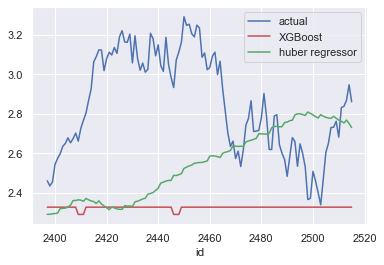

In [28]:
#  = len(y_test)

y_test[:].plot(color="b", label="actual")
plt.plot(y_test.index[:], y_preds[:], color="r", label="XGBoost")
plt.plot(y_test.index[:], hub_y_preds[:], color="g", label="huber regressor")

plt.legend()

plt.show()